# KMean Clustering Spotify Song Recommendations

## Imports

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

## Constants

In [97]:
FOLDER = "Datasets/"
spotify = 'genres_v2.csv'
playlists = 'playlists.csv'
spotify = 'dataset.csv'

## Data Input

In [98]:
df = pd.read_csv(os.path.join(FOLDER,spotify))

## Data Exploration and Preprocessing

In [99]:
df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

In [101]:
df.shape

(114000, 21)

Drop unneeded Unnamed column

In [102]:
df = df.drop(['Unnamed: 0'], axis=1)

Check for null values

In [103]:
df.isnull().sum(axis=1).value_counts()

0    113999
3         1
Name: count, dtype: int64

View rows with null values, only one row has null values so it can be dropped

In [104]:
rows_with_null = df[df.isnull().any(axis=1)]
rows_with_null

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
65900,1kR4gIb7nGxHPI3D2ifs59,NaN,NaN,NaN,0,0,False,0.501,0.583,7,-9.46,0,0.0605,0.69,0.00396,0.0747,0.734,138.391,4,k-pop


Drop null value rows

In [105]:
df.dropna(inplace=True)

Identify duplicated rows, only 450 duplicate rows out of 113998, so can be dropped

In [106]:
# Identify and display duplicate rows
duplicate_rows = df[df.duplicated()]
duplicate_rows.count()

track_id            450
artists             450
album_name          450
track_name          450
popularity          450
duration_ms         450
explicit            450
danceability        450
energy              450
key                 450
loudness            450
mode                450
speechiness         450
acousticness        450
instrumentalness    450
liveness            450
valence             450
tempo               450
time_signature      450
track_genre         450
dtype: int64

Drop duplicates

In [107]:
df.drop_duplicates(inplace=True)

Identify numerical columns

In [108]:
# Selecting numerical columns
clustering_features = df.select_dtypes(include=['int64', 'float64'])
clustering_features

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,73,230666,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4
1,55,149610,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4
2,57,210826,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4
3,71,201933,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3
4,82,198853,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,21,384999,0.172,0.2350,5,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5
113996,22,385000,0.174,0.1170,0,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4
113997,22,271466,0.629,0.3290,0,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4
113998,41,283893,0.587,0.5060,7,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4


View data distribution in numerical columns to identify any skews in data or outlier values. From the charts we can see that:
1. Features have very different scales so will need normalisation.
2. Time Signature is highly skewed with most songs in the 4 category, dropping this column may be necessary.
3. Mode is binary, either 0 or 1, with a skew towards 1.
4. Instrumentalness has mostly very low values, normalisation should fix any imbalance this may cause.
5. Many columns such dancebility and loudness have a normal distribution.

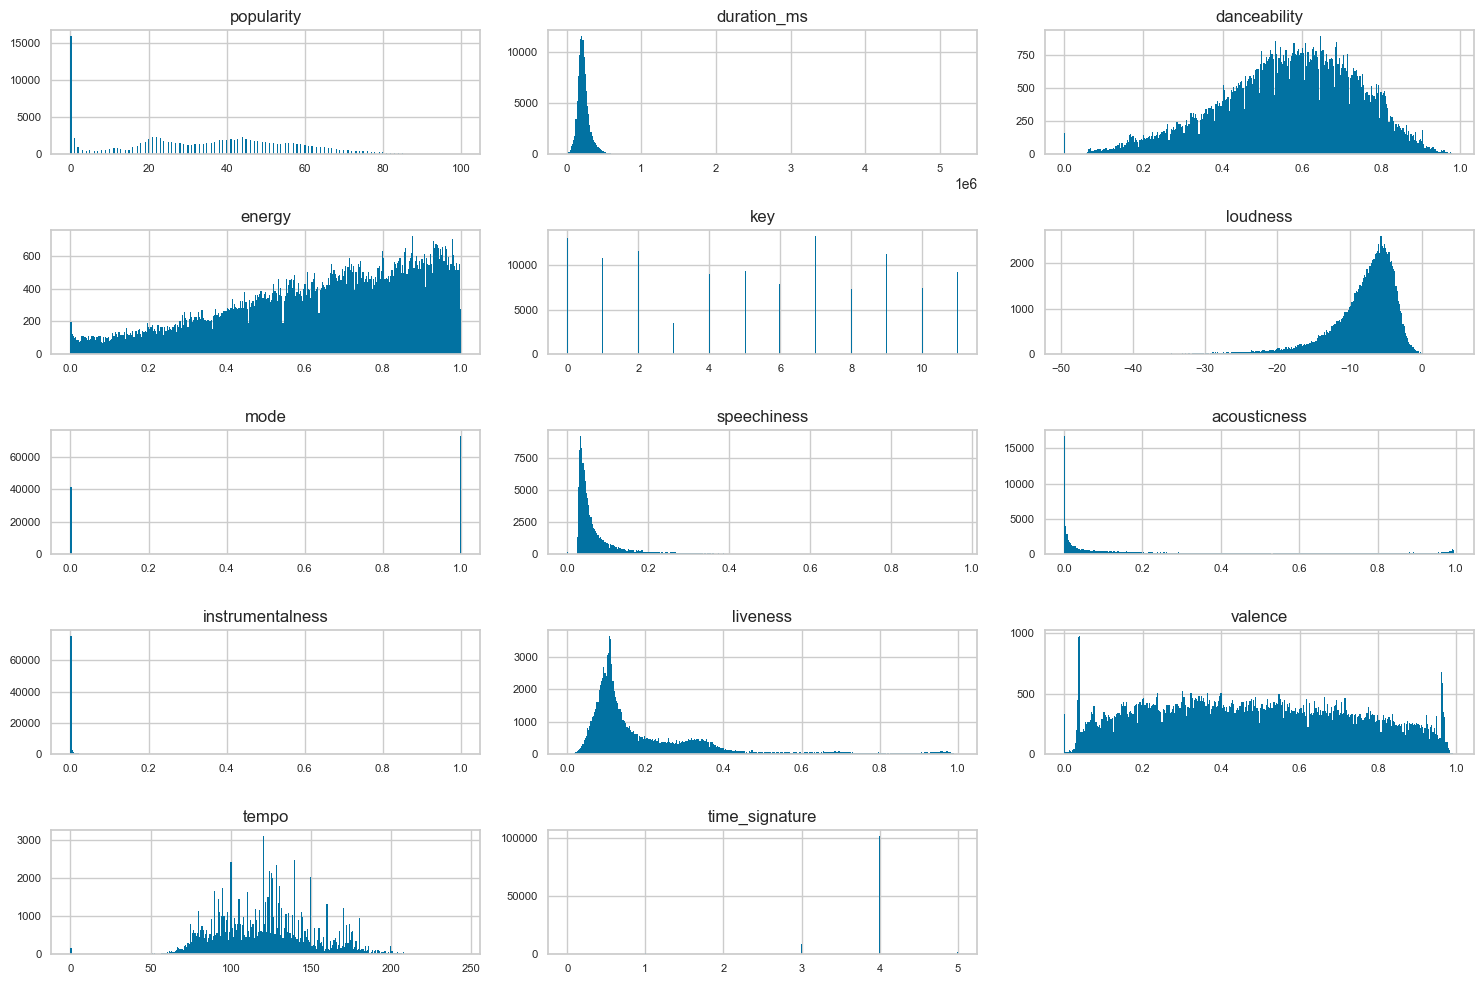

In [109]:
#14 numerical features
num_rows = 5
num_cols = 3
total_plots = 14

plt.figure(figsize=(15, 10))

for i, col in enumerate(clustering_features.columns):
    plt.subplot(num_rows, num_cols, i+1)
    plt.hist(clustering_features[col], bins='sqrt')
    plt.title(col, fontsize=12)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

# Adjust layout
plt.tight_layout()

plt.show()

Use MinMaxScalar to normalise features.

In [110]:
clustering_features = df.select_dtypes(include=['int64', 'float64'])
clustering_features
scaler = MinMaxScaler()
# Scale numerical columns
X_scale = scaler.fit_transform(clustering_features)

Convert back to dataframe to view results.

In [111]:
# Convert the scaled array back into a DataFrame
X_scaled_df = pd.DataFrame(X_scale, columns=clustering_features.columns)
X_scaled_df

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,0.73,0.042473,0.686294,0.4610,0.090909,0.791392,0.0,0.148187,0.032329,0.000001,0.3580,0.718593,0.361245,0.8
1,0.55,0.026971,0.426396,0.1660,0.090909,0.597377,1.0,0.079067,0.927711,0.000006,0.1010,0.268342,0.318397,0.8
2,0.57,0.038679,0.444670,0.3590,0.000000,0.736123,1.0,0.057720,0.210843,0.000000,0.1170,0.120603,0.313643,0.8
3,0.71,0.036978,0.270051,0.0596,0.000000,0.573701,1.0,0.037617,0.908635,0.000071,0.1320,0.143719,0.746758,0.6
4,0.82,0.036389,0.627411,0.4430,0.181818,0.737103,1.0,0.054508,0.470884,0.000000,0.0829,0.167839,0.492863,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113544,0.21,0.071990,0.174619,0.2350,0.454545,0.612952,1.0,0.043731,0.642570,0.928000,0.0863,0.034070,0.517705,1.0
113545,0.22,0.071990,0.176650,0.1170,0.000000,0.577345,0.0,0.041554,0.997992,0.976000,0.1050,0.035176,0.350242,0.8
113546,0.22,0.050276,0.638579,0.3290,0.000000,0.714648,0.0,0.043523,0.870482,0.000000,0.0839,0.746734,0.543933,0.8
113547,0.41,0.052653,0.595939,0.5060,0.636364,0.714759,1.0,0.030777,0.382530,0.000000,0.2700,0.415075,0.558651,0.8


Visualise new distributions. Looking at results show that time signature should probably be dropped as it is highly skewed and unlikely to be deterministic in clustering.

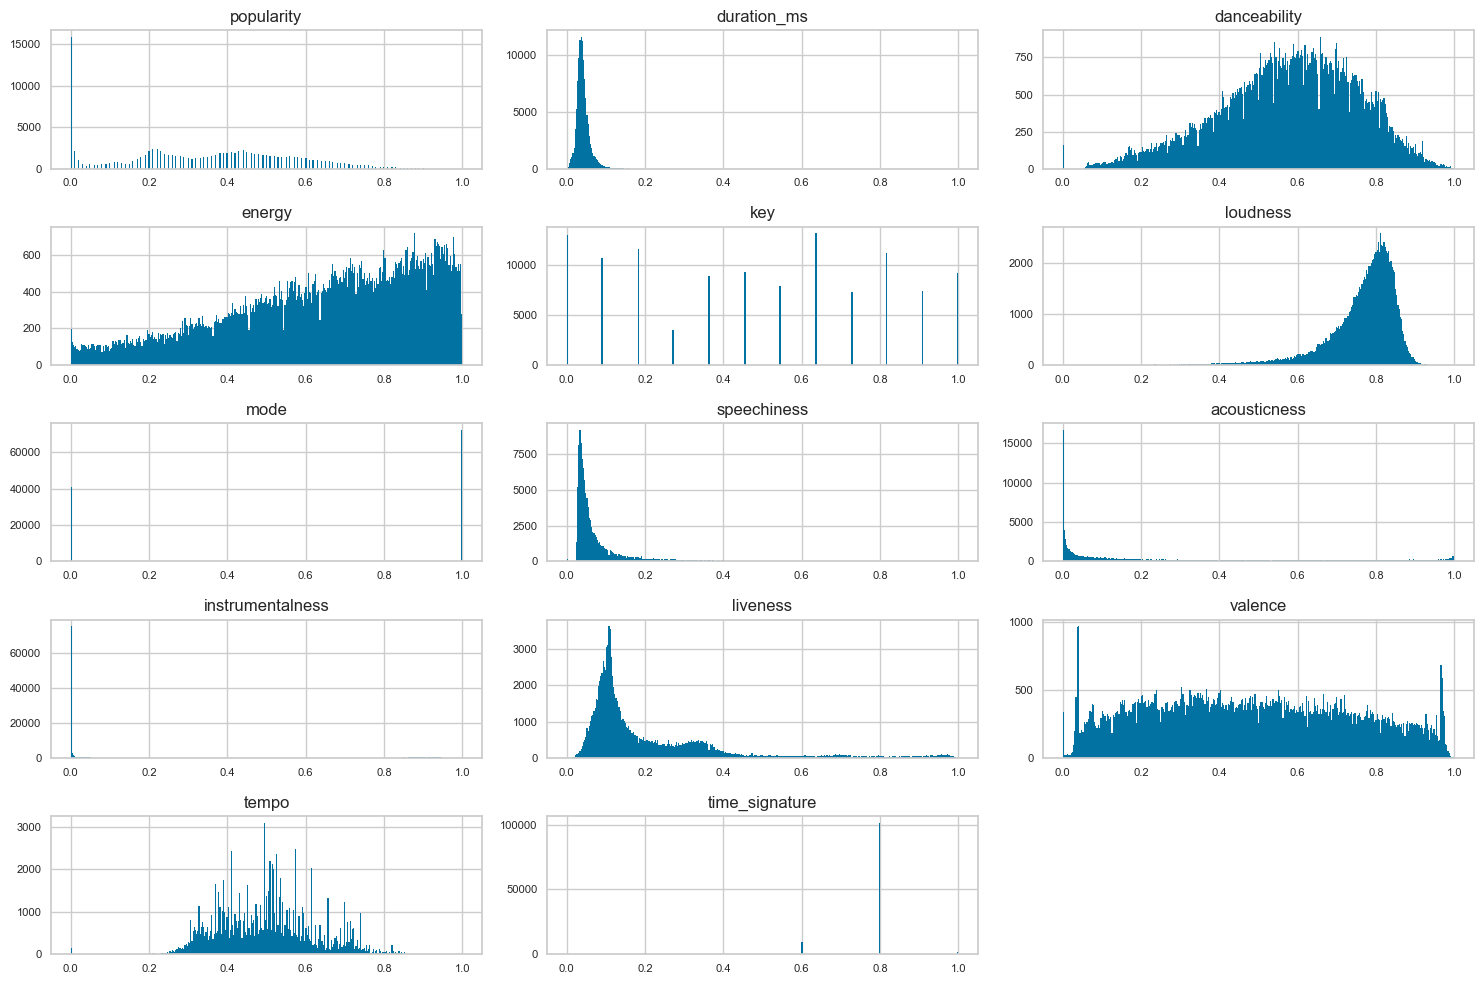

In [112]:
#14 numerical features
num_rows = 5
num_cols = 3
total_plots = 14

plt.figure(figsize=(15, 10))

for i, col in enumerate(X_scaled_df.columns):
    plt.subplot(num_rows, num_cols, i+1)
    plt.hist(X_scaled_df[col], bins='sqrt')
    plt.title(col, fontsize=12)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

# Adjust layout
plt.tight_layout()

plt.show()

Drop time signature column

In [113]:
X_scaled_df = X_scaled_df.drop(['time_signature'], axis=1)

In [114]:
#Convery to numpy array
X_scale = X_scaled_df.values

## Model Creation

### Model 1
For model one, we pick a random n for first attempt

In [115]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_scale)

KMeans(n_clusters=3)

#### Model Evaluation

##### Inertia (sum of squares)

Inertia is the sum of squares distances of samples to their cluster centroid. Higher values indicate clusters are more spread out and less well defined.

In [116]:
kmeans.inertia_

57483.629594783895

Given that all feature are on a scale between 0 and 1 this score seems high. However, this figure will really be more useful as a comparison measure against other model attempts

#### Silhouette score

Silhouette score is another metric which can be used. It not only considered the distances of samples to their own cluster centroid but also the average distance of samples to samples in their nearest neighbouring cluster. Higher silhouette scores indicate that clusters are well seperated from other clusters and have high cohesion. Silhouette score is between 1 and -1 with higher values indicating better performance.

In [117]:
# Calculate Silhouette Score
silhouette_avg = silhouette_score(X_scale, kmeans.labels_)
silhouette_avg

0.25838747359219943

At .25, the silhouette score is reasonable but indicates that there is overlap between clusters and there is room for improvement.

### Model 2
Model 2 will use the Elbow method to pick the best n value for clustering. It gets the inertia score for n values and picks the n value where the inertia rate of decreasing begins to slow. Will try n values from 1 to 40.

In [118]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# List for inertia values
inertia = []

# Range of clusters
clusters_range = range(1, 40)

# Calculate inertia for each
for k in clusters_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_scale)
    inertia.append(kmeans.inertia_)

Visualise inertia rate of decrease on graph.

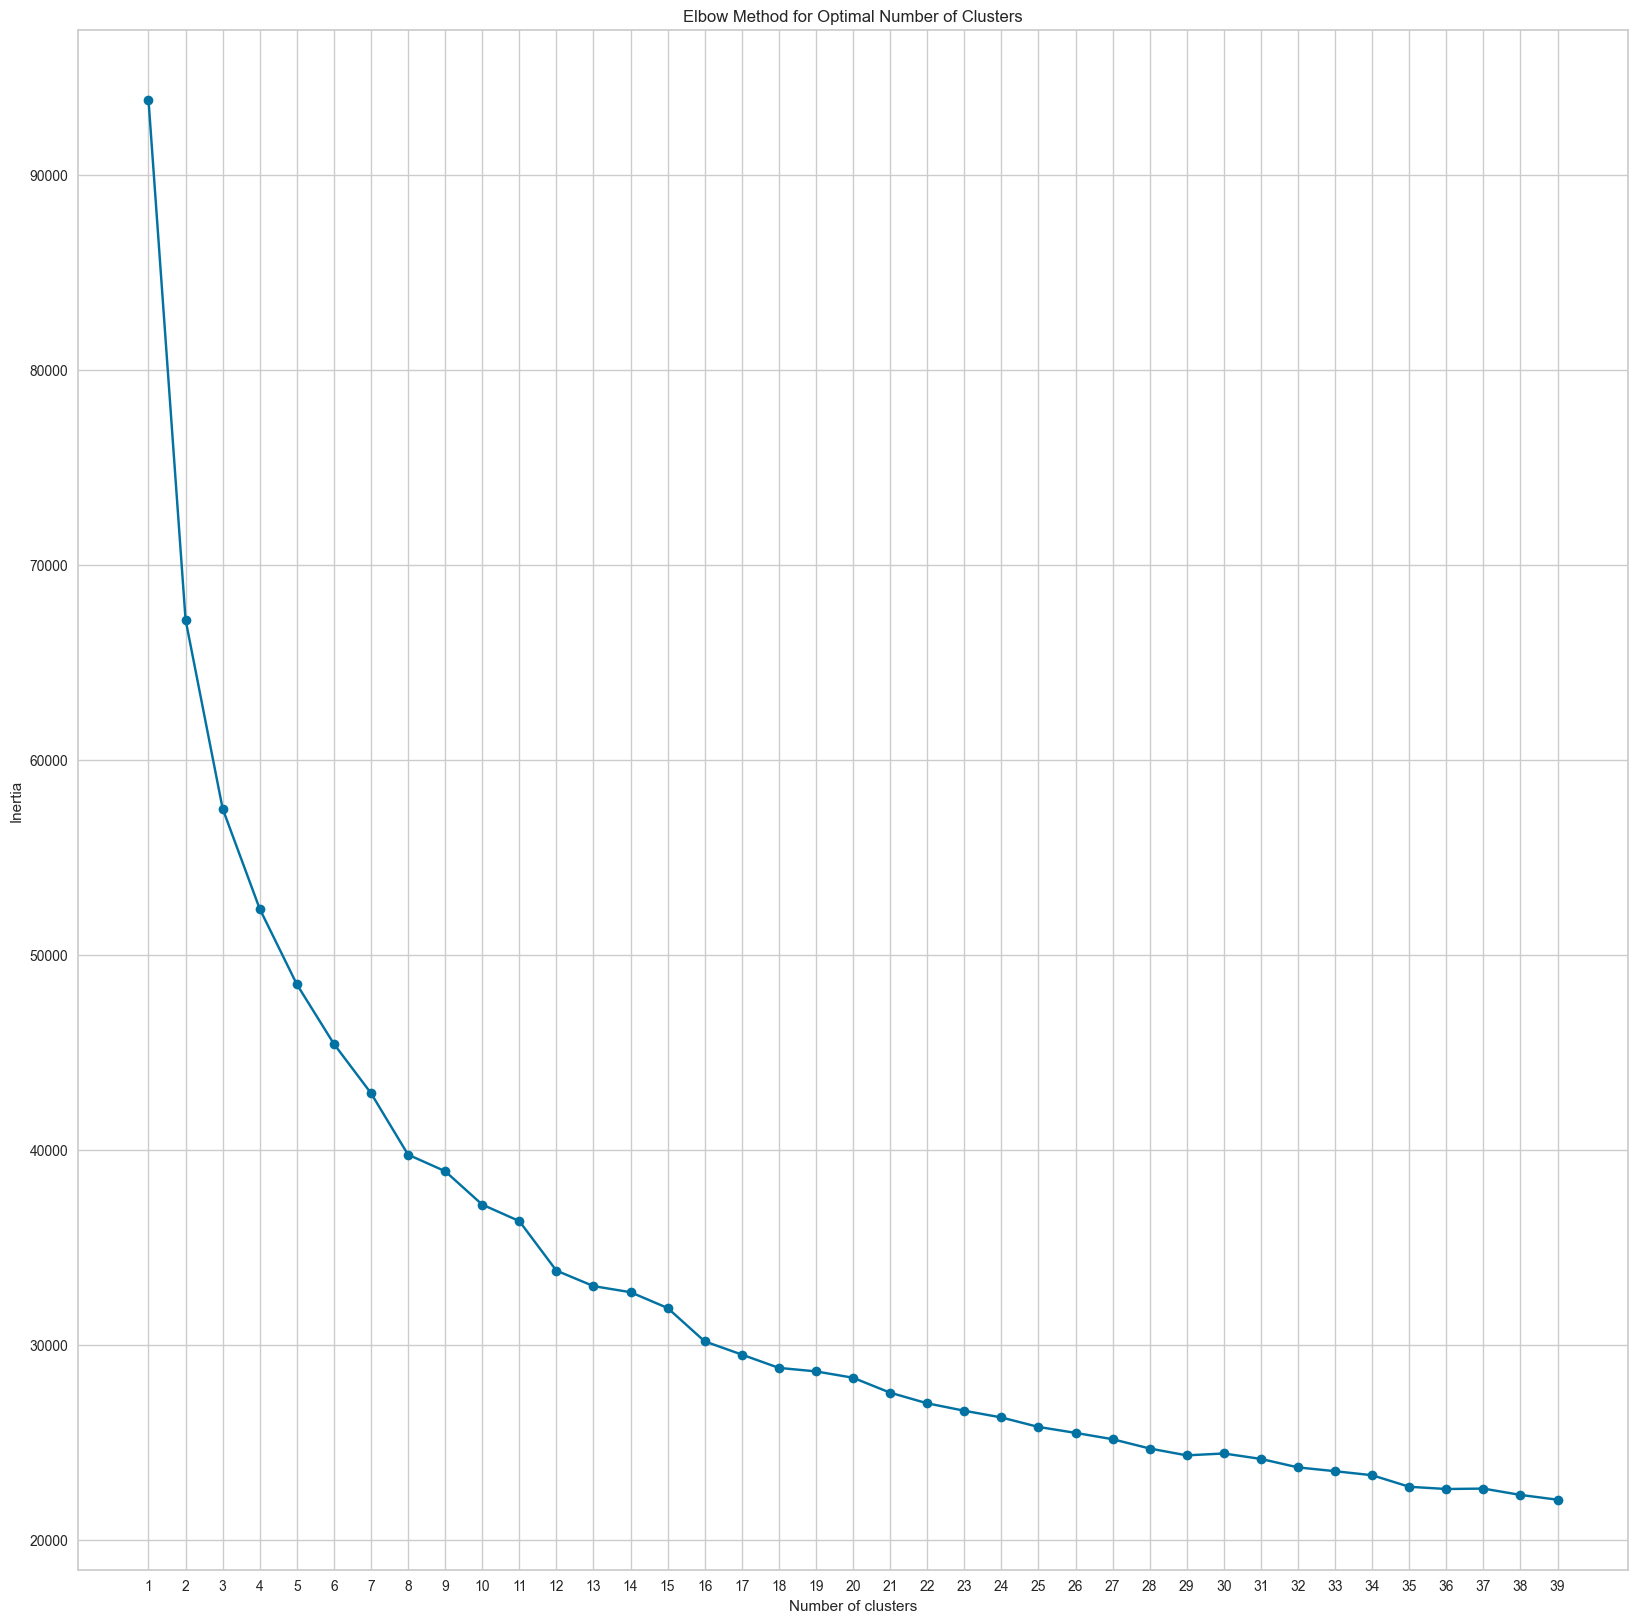

In [119]:
# Plot the elbow
plt.figure(figsize=(20, 20))
plt.plot(clusters_range, inertia, marker='o', linestyle='-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xticks(clusters_range)
plt.show()

In [120]:
diff = []

# Calculate differences in inertia
for i in range(1, len(inertia)):
    diff.append(inertia[i] - inertia[i-1])

# Find max differnce and its index
max_diff = max(diff)
index = diff.index(max_diff)

# Optimal number of clusters
print("Optimal number of clusters:", clusters_range[index + 1])

Optimal number of clusters: 30


Implement k means with optimal value

In [124]:
# Initialize KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=30)
kmeans.fit(X_scale)
y_kmeans = kmeans.predict(X_scale)

##### Model Evaluation

##### Inertia

In [125]:
kmeans.inertia_

24168.67634971205

Inertia value is greatly improved from 57483 to 24168 indicating that the clusters are much more cohesive and well defined in Model 2.

Silhouette

In [126]:
# Calculate Silhouette Score
silhouette_avg = silhouette_score(X_scale, kmeans.labels_)
silhouette_avg

0.14979727848001037

However silhouette score has decreased indicating that overlap between clusters has increased over Model 1.

#### Model 3
In this model we will attempt to use silhouette score to determine optimal k. The values were picked from viewing graph and looking for other possible inertia decrease points.  Credit to this website for code: https://builtin.com/data-science/elbow-method

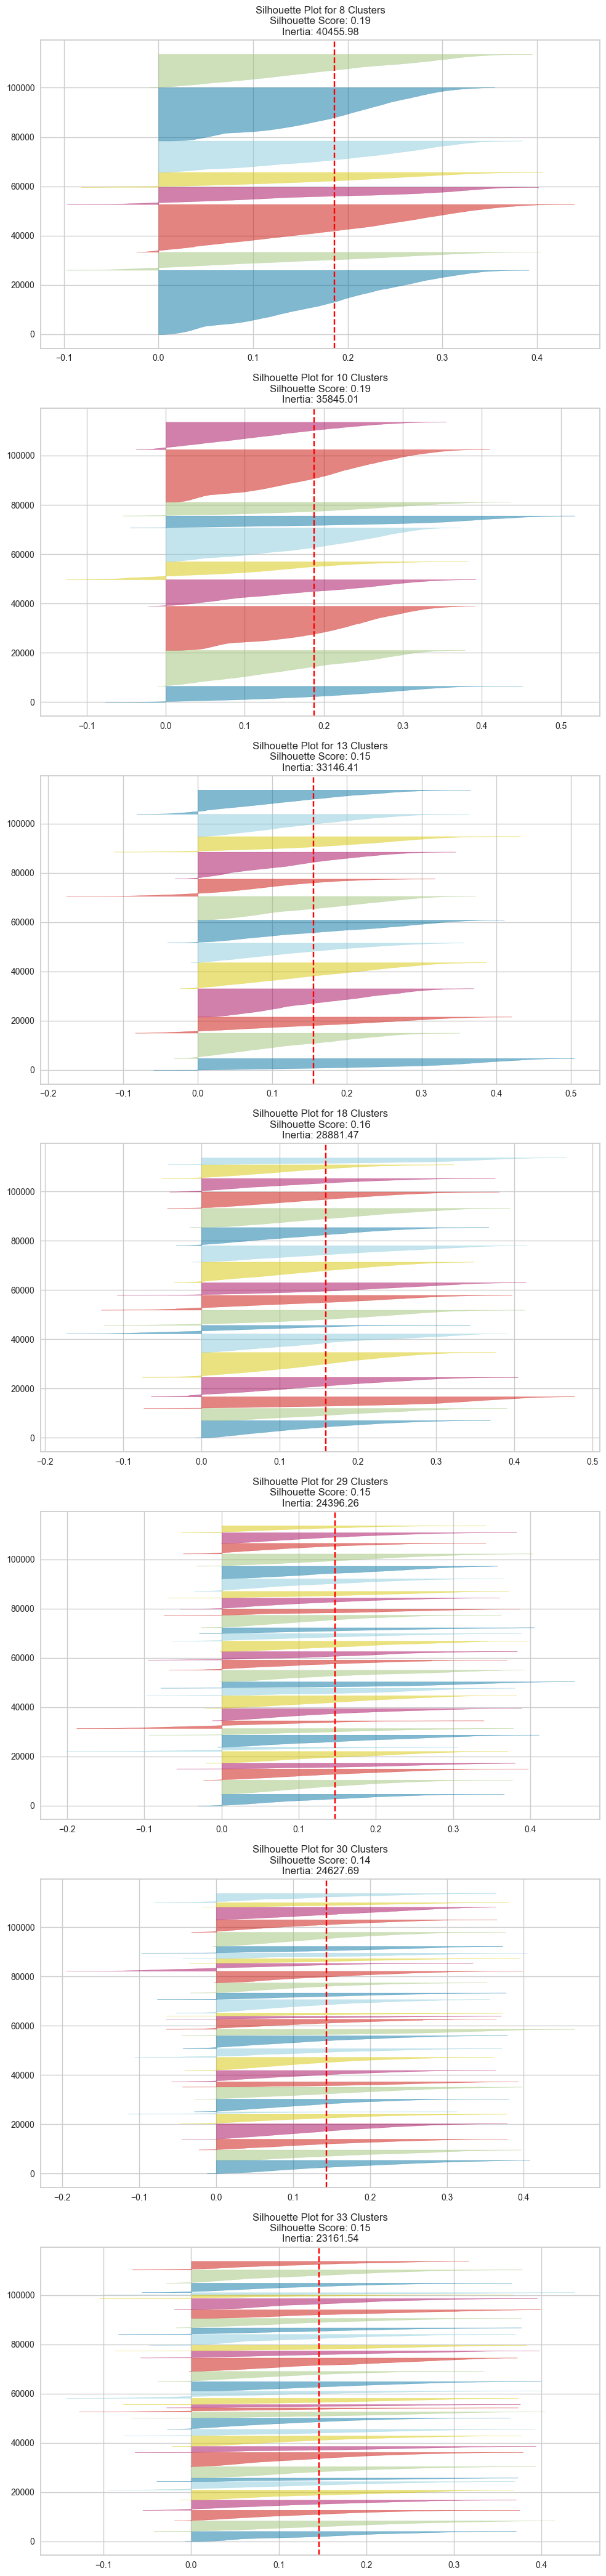

In [127]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# List for silhouette scores
silhouette = []
# List for inertia values
inertia = []

# Range of clusters
clusters_range = [8, 10, 13, 18, 29, 30, 33]  # From viewing graph for other possible inertia decrease points

fig, ax = plt.subplots(len(clusters_range), figsize=(10, 6 * len(clusters_range)))

# Loop over different numbers of clusters
for i, k in enumerate(clusters_range):
    # Create KMeans instance
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_scale)
    #Get inertia
    inertia.append(kmeans.inertia_)

    # Calculate silhouette score
    silhouette_score_value = silhouette_score(X_scale, kmeans.labels_)
    silhouette.append(silhouette_score_value)
    
    # Create SilhouetteVisualizer instance and fit
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax[i])
    visualizer.fit(X_scale)
    
    # Annotate silhouette score on the plot
    ax[i].set_title(f'Silhouette Plot for {k} Clusters\nSilhouette Score: {silhouette_score_value:.2f}\nInertia: {kmeans.inertia_:.2f}')

# Show the plots
plt.tight_layout()
plt.show()

Create model using n = 33

In [128]:
# Initialize KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=30)
kmeans.fit(X_scale)
y_kmeans = kmeans.predict(X_scale)

In [129]:
y_kmeans

array([ 3, 26,  4, ..., 17, 14, 17])

Add the cluster number to both dataframes

In [148]:
df['cluster'] = y_kmeans
X_scaled_df['cluster'] = y_kmeans

Get a songs' artist name and track name to test model

In [131]:
df.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,cluster
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,...,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,3
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,...,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,26
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,...,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,4
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,...,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,26
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,...,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,26


In [136]:
df[(df['artists'] == "Kina Grannis") & (df['album_name'] == "The Living Room Sessions Vol. 3") & (df['track_name'] == "Can't Help Falling In Love")]

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,cluster
533,14UvqLsdqw2dsmVkmTYptE,Kina Grannis,The Living Room Sessions Vol. 3,Can't Help Falling In Love,48,188354,False,0.444,0.143,0,...,1,0.0302,0.925,0.000069,0.118,0.132,100.341,3,acoustic,26


Build function to implement recommender system. First find song.

In [139]:
def recommender(df, artist_name, album_name, track_name):
    # Find the song in the dataset
    song_index = df[(df['artists'] == artist_name) & (df['album_name'] == album_name) & (df['track_name'] == track_name)].index
    if len(song_index) == 0:
        print("Song not found.")
        return None
    return song_index


In [140]:
recommender(df, "Kina Grannis","The Living Room Sessions Vol. 3", "Can't Help Falling In Love")

Index([533], dtype='int64')

Find song cluster

In [144]:
def recommender(df, artist_name, album_name, track_name):
    # Find the song in the dataset
    song_index = df[(df['artists'] == artist_name) & (df['album_name'] == album_name) & (df['track_name'] == track_name)].index
    if len(song_index) == 0:
        print("Song not found.")
        return None

    # Get song cluster
    song_cluster = df.loc[song_index, 'cluster'].values[0]
    return song_cluster

In [145]:
recommender(df, "Kina Grannis","The Living Room Sessions Vol. 3", "Can't Help Falling In Love")

26

Find song centroid

In [151]:
def recommender(df, artist_name, album_name, track_name, kmeans, X_scaled_df):
    # Find the song in the dataset
    song_index = df[(df['artists'] == artist_name) & (df['album_name'] == album_name) & (df['track_name'] == track_name)].index
    if len(song_index) == 0:
        print("Song not found.")
        return None

    # Get song cluster
    song_cluster = X_scaled_df.loc[song_index, 'cluster'].values[0]
    
    # Get centroid of cluster
    cluster_centroid = kmeans.cluster_centers_[song_cluster]
    return cluster_centroid

In [153]:
recommender(df, "Kina Grannis","The Living Room Sessions Vol. 3", "Can't Help Falling In Love",kmeans,X_scaled_df)

array([0.51770209, 0.04182305, 0.54695705, 0.36555646, 0.19531608,
       0.72085242, 1.        , 0.05200835, 0.71971479, 0.02101266,
       0.15631828, 0.32942081, 0.48163959])

Calculate pairwise distances for song cluster. Credit for code: https://copyprogramming.com/howto/get-nearest-point-to-centroid-scikit-learn?utm_content=cmp-true

In [158]:
from sklearn.metrics import pairwise_distances
def recommender(df, artist_name, album_name, track_name, kmeans, X_scaled_df):
    # Find the song in the dataset
    song_index = df[(df['artists'] == artist_name) & (df['album_name'] == album_name) & (df['track_name'] == track_name)].index
    if len(song_index) == 0:
        print("Song not found.")
        return None

    # Get song cluster index
    song_cluster_index = X_scaled_df.loc[song_index, 'cluster'].values[0]
    
    # Filter dataframe to include only songs from the same cluster
    cluster_df = X_scaled_df[X_scaled_df['cluster'] == song_cluster_index]

    # Get song cluster values
    song_cluster = cluster_df.drop(columns=['cluster']).values

    # Get centroid of cluster
    cluster_centroid = kmeans.cluster_centers_[song_cluster_index]

    # Calculate pairwise distances for songs in cluster
    distances = pairwise_distances( song_cluster, [cluster_centroid])
    return distances

In [159]:
recommender(df, "Kina Grannis","The Living Room Sessions Vol. 3", "Can't Help Falling In Love",kmeans,X_scaled_df)

array([[0.39955363],
       [0.63936778],
       [0.44533111],
       ...,
       [0.29950557],
       [0.37069423],
       [0.32853317]])

Now return the 10 smallest distances, get their index and return song ids

In [168]:
from sklearn.metrics import pairwise_distances
def recommender(df, artist_name, album_name, track_name, kmeans, X_scaled_df):
    # Find the song in the dataset
    song_index = df[(df['artists'] == artist_name) & (df['album_name'] == album_name) & (df['track_name'] == track_name)].index
    if len(song_index) == 0:
        print("Song not found.")
        return None

    # Get song cluster index
    song_cluster_index = X_scaled_df.loc[song_index, 'cluster'].values[0]
    
    # Filter dataframe to include only songs from the same cluster
    cluster_df = X_scaled_df[X_scaled_df['cluster'] == song_cluster_index]

    # Get song cluster values
    song_cluster = cluster_df.drop(columns=['cluster']).values

    # Get centroid of cluster
    cluster_centroid = kmeans.cluster_centers_[song_cluster_index]

    # Calculate pairwise distances for songs in cluster
    distances = pairwise_distances( song_cluster, [cluster_centroid])

    # Find the indices of the closest songs
    closest_indices = np.argsort(distances.flatten())[:10]

    # Get track IDs of closest songs
    closest_track_ids = df.iloc[closest_indices]['track_id'].tolist()
    
    return closest_track_ids   

In [174]:
song_recommend = recommender(df, "Kina Grannis","The Living Room Sessions Vol. 3", "Can't Help Falling In Love",kmeans,X_scaled_df)

In [177]:
len(song_recommend)

10

Now we create a function to return song details for those track ids

In [184]:
def get_song_info(df, track_ids):
    tracks = []
    for id in track_ids:
        track_info = df.loc[df['track_id'] == id, ['artists', 'track_name', 'album_name']].values[0]
        tracks.append(track_info)
    return tracks

Here we produce a list of song recommendations. Here is where unsupervised learning would need to incorporate domain knowledge to further evaluate this model. Song preference is such a subjective task that we would need to bring in experts with indepth knowledge of musical tastes and/or test these recommendations on a large group of volunteers to see if these recommedations are in any way useful/accurate.

In [185]:
get_song_info(df, song_recommend)

[array(['Jackie Mittoo', 'Reggae Rock', 'The Keyboard King at Studio One'],
       dtype=object),
 array(['Masaharu Fukuyama', "IT'S ONLY LOVE", "IT'S ONLY LOVE"],
       dtype=object),
 array(['Los Bunkers', 'Quién Fuera', 'Rock un sentimiento vol. I'],
       dtype=object),
 array(['No Te Va Gustar', 'Cielo De Un Solo Color',
        'Aunque Cueste Ver El Sol'], dtype=object),
 array(['Red Hot Chili Peppers', 'Fire - Remastered', 'Kick It'],
       dtype=object),
 array(['Victor Rice', 'The Demander', 'Drink'], dtype=object),
 array(['Azarel;Leor', 'Who Am I (Psalm 8:4)', 'Who Am I (Psalm 8:4)'],
       dtype=object),
 array(['The Seige', 'Arise (From Marvel\'s "Cloak & Dagger")',
        'Arise (From Marvel\'s "Cloak & Dagger")'], dtype=object),
 array(['Rob Zombie', 'Living Dead Girl', 'Halloween Spooky Party 2022'],
       dtype=object),
 array(['Voilaaa', 'Jungle Fire', "On te l'avait dit"], dtype=object)]

## Save model and dataframes

Save model and dataframes for later implementation

In [186]:
import pickle

with open('Model/kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

df.to_csv('Model/df.csv', index=False)
X_scaled_df.to_csv('Model/X_scaled_df.csv', index=False)